## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time

In [8]:
# reading the Treebank tagged sentences
data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [9]:
print(data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [10]:
# split data into training and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(data, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Testing Set Length -", len(test_set))
print("-" * 100)
print("Training Data -\n")
print(train_set[:10])

Training Set Length - 3718
Testing Set Length - 196
----------------------------------------------------------------------------------------------------
Training Data -

[[('Montedison', 'NOUN'), ('currently', 'ADV'), ('owns', 'VERB'), ('about', 'ADP'), ('72', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Erbamont', 'NOUN'), ("'s", 'PRT'), ('common', 'ADJ'), ('shares', 'NOUN'), ('outstanding', 'ADJ'), ('.', '.')], [('Plans', 'NOUN'), ('that', 'DET'), ('*T*-13', 'X'), ('give', 'VERB'), ('advertisers', 'NOUN'), ('discounts', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('maintaining', 'VERB'), ('or', 'CONJ'), ('increasing', 'VERB'), ('ad', 'NOUN'), ('spending', 'NOUN'), ('have', 'VERB'), ('become', 'VERB'), ('permanent', 'ADJ'), ('fixtures', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('news', 'NOUN'), ('weeklies', 'NOUN'), ('and', 'CONJ'), ('underscore', 'VERB'), ('the', 'DET'), ('fierce', 'ADJ'), ('competition', 'NOUN'), ('between', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('Time', 'NOUN'), ('Warner', 

In [11]:
# Getting list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Train Tagged Words - ", len(train_tagged_words))

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Train Tagged Words - ", len(test_tagged_words))


# Let's have a look at the tagged words in the training set
train_tagged_words[:10]

Train Tagged Words -  95490
Train Tagged Words -  5186


[('Montedison', 'NOUN'),
 ('currently', 'ADV'),
 ('owns', 'VERB'),
 ('about', 'ADP'),
 ('72', 'NUM'),
 ('%', 'NOUN'),
 ('of', 'ADP'),
 ('Erbamont', 'NOUN'),
 ("'s", 'PRT'),
 ('common', 'ADJ')]

In [15]:
 #tokens in the train set - train_tagged_words
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['Montedison',
 'currently',
 'owns',
 'about',
 '72',
 '%',
 'of',
 'Erbamont',
 "'s",
 'common']

In [16]:
# POS tags for the tokens in the train set - train_tagged_words

train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:10]

['NOUN', 'ADV', 'VERB', 'ADP', 'NUM', 'NOUN', 'ADP', 'NOUN', 'PRT', 'ADJ']

In [17]:
# building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)

In [18]:
# building the POS tags to a set
training_pos_tag_set = set(train_tagged_pos_tokens)

In [19]:
# let's check how many unique tags are present in training data
print(len(training_pos_tag_set))

12


In [20]:
# let's check how many words are present in vocabulary
print(len(training_vocabulary_set))

12049


### Build the vanilla Viterbi based POS tagger

In [37]:
# compute emission probability for a given word for a given tag
def word_given_tag_emission(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)    
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]    
    word_given_tag_count = len(word_given_tag_list)    
    
    return (word_given_tag_count, tag_count)

In [38]:
# compute transition probabilities of a previous and next tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags_list = [tag for tag in tags if tag == t1]
    t1_tags_count = len(t1_tags_list)
    
    t2_given_t1_list = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    t2_given_t1_count = len(t2_given_t1_list)
    
    return(t2_given_t1_count, t1_tags_count)

In [39]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix.

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

In [40]:
# creating t x t transition matrix of training_pos_tag_set


tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float64')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [41]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [42]:
tags_df

,NUM,ADJ,ADP,PRT,.,DET,PRON,X,VERB,ADV,CONJ,NOUN
NUM,0.185534,0.032637,0.034696,0.027639,0.117024,0.002940,0.001470,0.211996,0.017936,0.002940,0.013819,0.351367
ADJ,0.020429,0.065936,0.077230,0.010962,0.066102,0.004816,0.000498,0.021425,0.012290,0.004816,0.017107,0.698389
ADP,0.063275,0.105708,0.016674,0.001496,0.040081,0.323536,0.069260,0.034203,0.008551,0.014002,0.000962,0.322253
PRT,0.058192,0.083550,0.019506,0.001951,0.043238,0.101105,0.017880,0.013004,0.399870,0.010078,0.001951,0.249675
.,0.082187,0.044780,0.091359,0.002248,0.091808,0.172916,0.065552,0.027785,0.088751,0.052963,0.057279,0.222282
DET,0.021921,0.204190,0.009568,0.000242,0.018045,0.005571,0.003391,0.045537,0.039603,0.012595,0.000606,0.638731
PRON,0.007347,0.070766,0.022815,0.012761,0.040217,0.009281,0.007347,0.090487,0.488012,0.034803,0.005414,0.210750
X,0.002860,0.017321,0.144605,0.184967,0.165422,0.054028,0.055458,0.075799,0.201970,0.025584,0.010329,0.061656
VERB,0.022558,0.063317,0.092019,0.031581,0.035159,0.134023,0.035236,0.218030,0.169026,0.082141,0.005523,0.111388
ADV,0.032013,0.128713,0.118152,0.014191,0.136964,0.067987,0.015842,0.023102,0.345545,0.079208,0.006931,0.031353


In [21]:
# exploratory data analysis


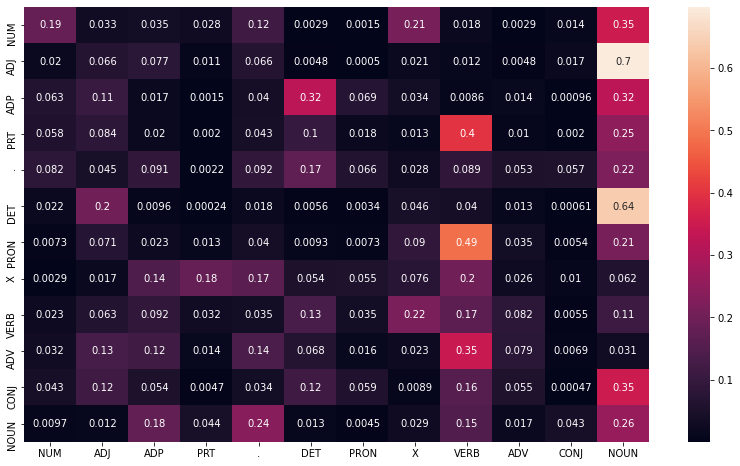

In [43]:
# heatmap of tags matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

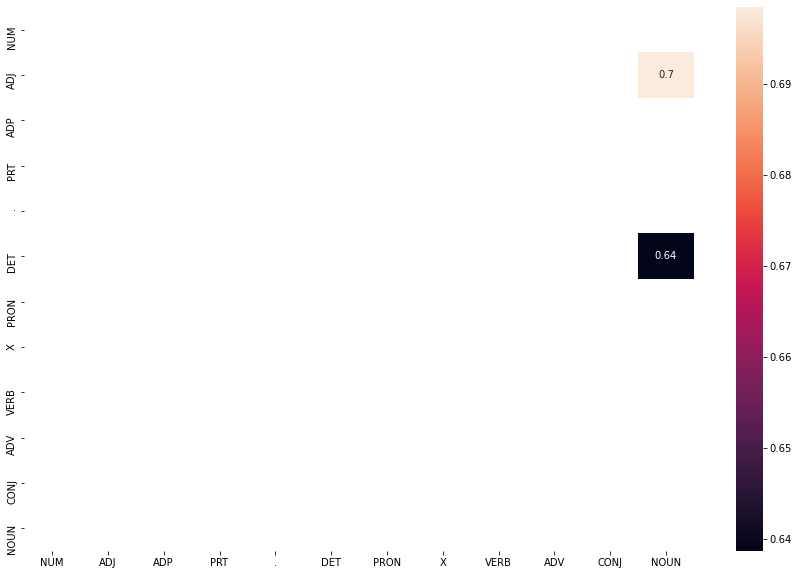

In [44]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(15, 10))
sns.heatmap(tags_frequent, annot = True)
plt.show()

In [45]:
# Vanilla Viterbi Algorithm
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag_emission(words[key], tag)[0]/word_given_tag_emission(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [46]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1, len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [47]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check)/len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Time taken in seconds:  16.928482055664062
Vanilla Viterbi Algorithm Accuracy:  86.60714285714286


In [48]:
# let's check the incorrectly tagged words
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

print("Total Incorrect Tagged Words :", len(incorrect_tagged_words))
print("\n")
print("Incorrect Tagged Words :", incorrect_tagged_words)

Total Incorrect Tagged Words : 15


Incorrect Tagged Words : [(('automated', 'NUM'), ('automated', 'VERB')), (('threatens', 'NUM'), ('threatens', 'VERB')), (('dinosaurs', 'NUM'), ('dinosaurs', 'NOUN')), (('stock-specialist', 'NUM'), ('stock-specialist', 'ADJ')), (('*T*-88', 'NUM'), ('*T*-88', 'X')), (('ushered', 'NUM'), ('ushered', 'VERB')), (('in', 'ADP'), ('in', 'PRT')), (('public', 'NOUN'), ('public', 'ADJ')), (('betterment', 'NUM'), ('betterment', 'NOUN')), (('Hoffman', 'NUM'), ('Hoffman', 'NOUN')), (('specializing', 'NUM'), ('specializing', 'VERB')), (('retaliation', 'NUM'), ('retaliation', 'NOUN')), (('intellectual', 'NUM'), ('intellectual', 'ADJ')), (('improvements', 'NUM'), ('improvements', 'NOUN')), (('ACQUISITION', 'NUM'), ('ACQUISITION', 'NOUN'))]


In [49]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - training_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 13


Unknown Words : ['ushered', 'stock-specialist', 'dinosaurs', 'improvements', 'specializing', 'threatens', 'ACQUISITION', '*T*-88', 'automated', 'intellectual', 'retaliation', 'Hoffman', 'betterment']


### Solve the problem of unknown words

In [50]:
#unigram

# Lexicon (or unigram tagger)

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.9012726571538758


In [51]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [52]:
# rule based tagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.9371384496721944


In [53]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.939259544928654


In [54]:
# Trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9379097570381797


In [55]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag_emission(words[key], tag)[0]/word_given_tag_emission(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [56]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',accuracy*100)

Time taken in seconds:  16.89920663833618
Vanilla Viterbi for Unknown Words Accuracy:  91.07142857142857


In [57]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('NUM', 0.03561629489998953),
 ('ADJ', 0.06305372290292177),
 ('ADP', 0.09797884595245575),
 ('PRT', 0.03221279715153419),
 ('.', 0.11646245680175935),
 ('DET', 0.08646978741229448),
 ('PRON', 0.027081369776939992),
 ('X', 0.06590218871085977),
 ('VERB', 0.1346318986281286),
 ('ADV', 0.03173107131636821),
 ('CONJ', 0.022473557440569693),
 ('NOUN', 0.28638600900617867)]

In [59]:

def Vanilla_Viterbi_for_Unknown_Words_Modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag_emission(words[key], tag)[0]/word_given_tag_emission(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words_Modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified = len(viterbi_word_check)/len(tagged_seq) * 100
print('Modified Vanilla Viterbi for Unknown Words ACC: ', accuracy_viterbi_modified)

Time taken in seconds:  16.824286937713623
Modified Vanilla Viterbi for Unknown Words ACC:  91.96428571428571


In [62]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [63]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_Trigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in training_vocabulary_set:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag_emission(words[key], tag)[0]/word_given_tag_emission(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [64]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(tagged_seq) * 100
print('Modified Viterbi Trigram Tagger Accuracy: ', viterbi_trigram_accuracy)

Time taken in seconds:  47.07866597175598
Modified Viterbi Trigram Tagger Accuracy:  96.42857142857143


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [65]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Vanilla Viterbi Modified', accuracy_viterbi_modified], 
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,86.607143
Vanilla Viterbi Modified,91.964286
Unigram Tagger,90.127266
Unigram + RegexpTagger,93.713845
Bigram Tagger + Unigram_tagger,93.925954
Trigram Tagger + Bigram_tagger,93.790976
Viterbi + Trigram_tagger,96.428571


<AxesSubplot:xlabel='Tagging_Algorithm'>

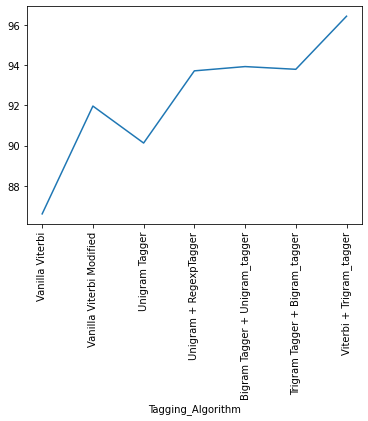

In [66]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [67]:
from nltk.tokenize import word_tokenize

In [68]:
## Testing
sentence_test_1 = 'Reliance and Facebook made a deal in 2020 that gave Reliance access to Facebook\'s firehose.'
words = word_tokenize(sentence_test_1)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Reliance', 'NOUN'), ('and', 'CONJ'), ('Facebook', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2020', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Reliance', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Facebook', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.')]


In [69]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Reliance', 'NOUN'), ('and', 'CONJ'), ('Facebook', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2020', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Reliance', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Facebook', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [70]:
sentence_test_2='Symbian is the least-selling OS on smartphones since 2011.'
words = word_tokenize(sentence_test_2)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Symbian', 'NUM'), ('is', 'VERB'), ('the', 'DET'), ('least-selling', 'NUM'), ('OS', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('.', '.')]


In [71]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Symbian', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('least-selling', 'ADJ'), ('OS', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('.', '.')]


In [75]:
sentence_test_3='She commented a Facebook post taken from smartphone and uploaded results to Insta.'
words = word_tokenize(sentence_test_3)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('She', 'PRON'), ('commented', 'NUM'), ('a', 'DET'), ('Facebook', 'NUM'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('smartphone', 'NUM'), ('and', 'CONJ'), ('uploaded', 'NUM'), ('results', 'NOUN'), ('to', 'PRT'), ('Insta', 'NUM'), ('.', '.')]


In [76]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('She', 'PRON'), ('commented', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Insta', 'NOUN'), ('.', '.')]
